<a href="https://colab.research.google.com/github/seunghee-lee/option/blob/main/Derivatives_Valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black Scholes valuation methods

In [1]:
import numpy as np
import scipy.stats as ss
from scipy.integrate import quad
from functools import partial
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def BlackScholes(payoff="call", S0=100.0, K=100.0, T=1.0, r=0.1, sigma=0.2):
    d1 = (np.log(S0 / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    if payoff == "call":
       return S0*ss.norm.cdf(d1) - K*np.exp(-r * T)*ss.norm.cdf(d2)
    elif payoff == "put":
       return K*np.exp(-r*T)*ss.norm.cdf(-d2) - S0*ss.norm.cdf(-d1)
    else:
       raise ValueError("invalid type. Set 'call' or 'put'")

In [4]:
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.035  # risk free rate
sig = 0.2  # volatility

In [5]:
call =BlackScholes("call", S0, K, T, r, sig)
put = BlackScholes("put", S0, K, T, r, sig)
print("Call price: ", call)
print("Put price: ", put)

Call price:  9.667467371387701
Put price:  6.228008997144336


#### Put-Call parity

In [6]:
print(call)
print(put + S0 - K * np.exp(-r * T))

9.667467371387701
9.667467371387701


#### Monte Carlo method

In [7]:
np.random.seed(seed=44)  # seed for random number generation
N = 10000000  # Number of random variables

W = ss.norm.rvs((r - 0.5 * sig**2) * T, np.sqrt(T) * sig, N)
S_T = S0 * np.exp(W)

call = np.mean(np.exp(-r * T) * np.maximum(S_T - K, 0))
put = np.mean(np.exp(-r * T) * np.maximum(K - S_T, 0))
call_err = ss.sem(np.exp(-r * T) * np.maximum(S_T - K, 0))  # standard error
put_err = ss.sem(np.exp(-r * T) * np.maximum(K - S_T, 0))  # standard error

In [8]:
print("Call price: {}, with error: {}".format(call, call_err))
print("Put price: {}, with error: {}".format(put, put_err))

Call price: 9.662697937910483, with error: 0.004510627984933323
Put price: 6.231549154069496, with error: 0.002901821083005663


#### Binomial tree

In [10]:
N = 15000  # number of periods or number of time steps
payoff = "call"  # payoff

dT = float(T) / N  # Delta t
u = np.exp(sig * np.sqrt(dT))  # up factor
d = 1.0 / u  # down factor

V = np.zeros(N + 1)  # initialize the price vector

# price S_T at time T
S_T = np.array([(S0 * u**j * d ** (N - j)) for j in range(N + 1)])

a = np.exp(r * dT)  # risk free compounded return
p = (a - d) / (u - d)  # risk neutral up probability
q = 1.0 - p  # risk neutral down probability

if payoff == "call":
    V[:] = np.maximum(S_T - K, 0.0)
else:
    V[:] = np.maximum(K - S_T, 0.0)

for i in range(N - 1, -1, -1):
    # the price vector is overwritten at each step
    V[:-1] = np.exp(-r * dT) * (p * V[1:] + q * V[:-1])

print("BS Tree Price: ", V[0])

BS Tree Price:  9.667334977885675


#### Limits of the model

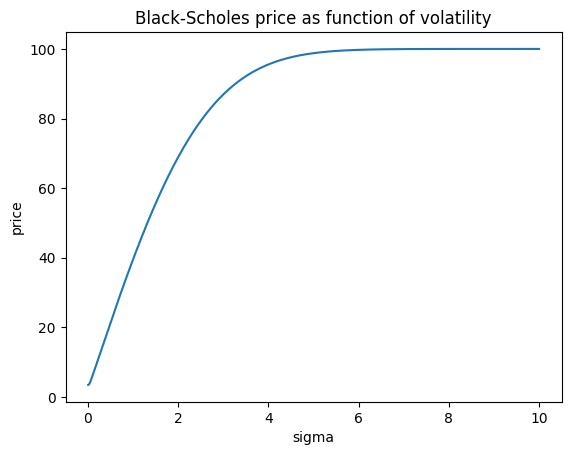

In [11]:
BS_sigma = partial(BlackScholes, "call", S0, K, T, r)  # binding the function
sigmas = np.linspace(0.01, 10, 1000)

plt.plot(sigmas, BS_sigma(sigmas))
plt.xlabel("sigma")
plt.ylabel("price")
plt.title("Black-Scholes price as function of volatility")
plt.show()

## American Option

### The Black-Scholes PDE

In [12]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time

%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
import sympy

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

In [13]:
r = 0.035
sig = 0.2
S0 = 100
X0 = np.log(S0)
K = 100
Texpir = 1

In [14]:
Nspace = 3000  # M space steps
Ntime = 2000  # N time steps

S_max = 3 * float(K)
S_min = float(K) / 3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

In [15]:
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

In [16]:
V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = np.exp(x_max) - K * np.exp(-r * T[::-1])  # boundary condition
V[0, :] = 0  # boundary condition

In [17]:
# construction of the tri-diagonal matrix D
sig2 = sig * sig
dxx = dx * dx

a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)

D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()

In [18]:
# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i]
    offset[-1] = c * V[-1, i]
    V[1:-1, i] = spsolve(D, (V[1:-1, i + 1] - offset))

In [19]:
# finds the option at S0
oPrice = np.interp(X0, x, V[:, 0])
print(oPrice)

9.666964975862907


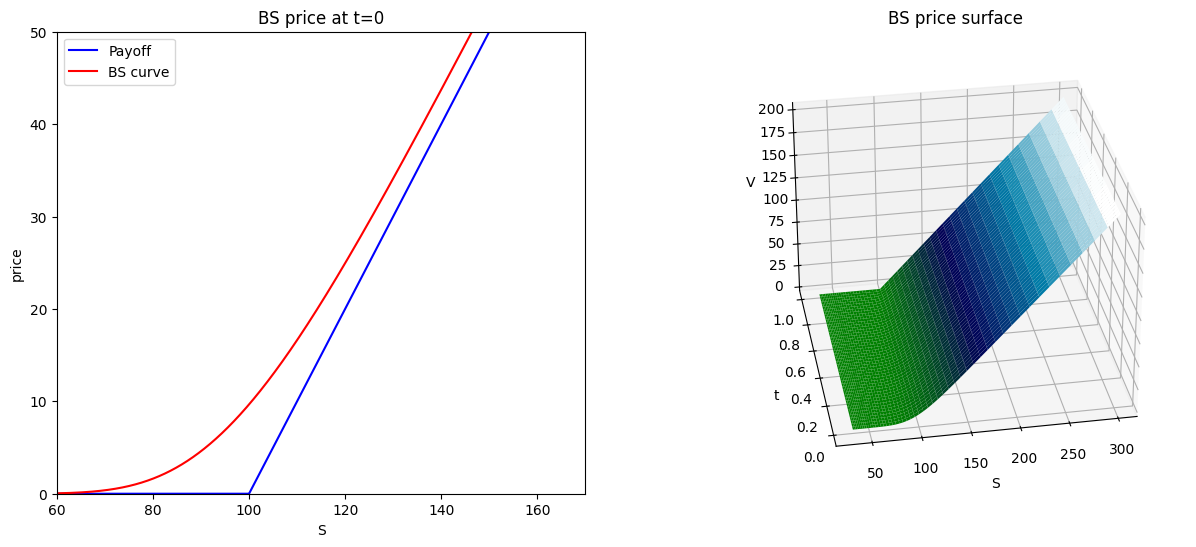

In [20]:
S = np.exp(x)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.plot(S, Payoff, color="blue", label="Payoff")
ax1.plot(S, V[:, 0], color="red", label="BS curve")
ax1.set_xlim(60, 170)
ax1.set_ylim(0, 50)
ax1.set_xlabel("S")
ax1.set_ylabel("price")
ax1.legend(loc="upper left")
ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(T, S)
ax2.plot_surface(Y, X, V, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("S")
ax2.set_ylabel("t")
ax2.set_zlabel("V")
ax2.view_init(30, -100)  # this function rotates the 3d plot
plt.show()

In [21]:
# BS_pricer.py file upload
from google.colab import files
src = list(files.upload().values())[0]

Saving BS_pricer.py to BS_pricer.py


In [22]:
open('BS_pricer.py','wb').write(src)
import BS_pricer

In [23]:
class Option_param:

    def __init__(self, S0=15, K=15, T=1, v0=0.04, payoff="call", exercise="European"):
        self.S0 = S0
        self.v0 = v0
        self.K = K
        self.T = T

        if exercise == "European" or exercise == "American":
            self.exercise = exercise
        else:
            raise ValueError("invalid type. Set 'European' or 'American'")

        if payoff == "call" or payoff == "put":
            self.payoff = payoff
        else:
            raise ValueError("invalid type. Set 'call' or 'put'")

In [24]:
class Diffusion_process:
    """
    Class for the diffusion process:
    r = risk free constant rate
    sig = constant diffusion coefficient
    mu = constant drift
    """

    def __init__(self, r=0.035, sig=0.2, mu=0.1):
        self.r = r
        self.mu = mu
        if sig <= 0:
            raise ValueError("sig must be positive")
        else:
            self.sig = sig

    def exp_RV(self, S0, T, N):
        W = ss.norm.rvs((self.r - 0.5 * self.sig**2) * T, np.sqrt(T) * self.sig, N)
        S_T = S0 * np.exp(W)
        return S_T.reshape((N, 1))

In [25]:
from BS_pricer import BS_pricer
# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="call")

# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.035, sig=0.2)

# Creates the object of the pricer
BS = BS_pricer(opt_param, diff_param)

price:  6.227773968725298


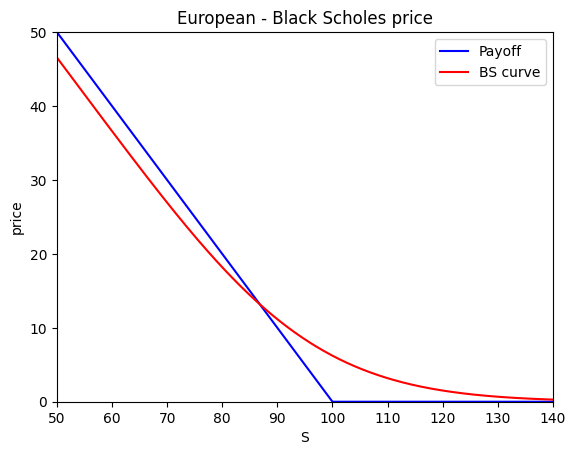

In [26]:
put_param = Option_param(S0=100, K=100, T=1, exercise="European", payoff="put")
# Creates the object of the put pricer
put = BS_pricer(put_param, diff_param)
print("price: ", put.PDE_price((5000, 4000)))
put.plot(axis=[50, 140, 0, 50])

### American options Pricing

In [27]:
# Creates the object with the parameters of the option
opt_param = Option_param(S0=100, K=100, T=1, exercise="American", payoff="put")
# Creates the object with the parameters of the process
diff_param = Diffusion_process(r=0.035, sig=0.2)
# Creates the pricer object
BS = BS_pricer(opt_param, diff_param)

In [28]:
BS.LSM(N=10000, paths=10000, order=2)  # Longstaff Schwartz Method

np.float64(6.630539485679515)

In [29]:
N_space = 8000
N_time = 5000
BS.PDE_price((N_space, N_time))

np.float64(6.569722434419303)

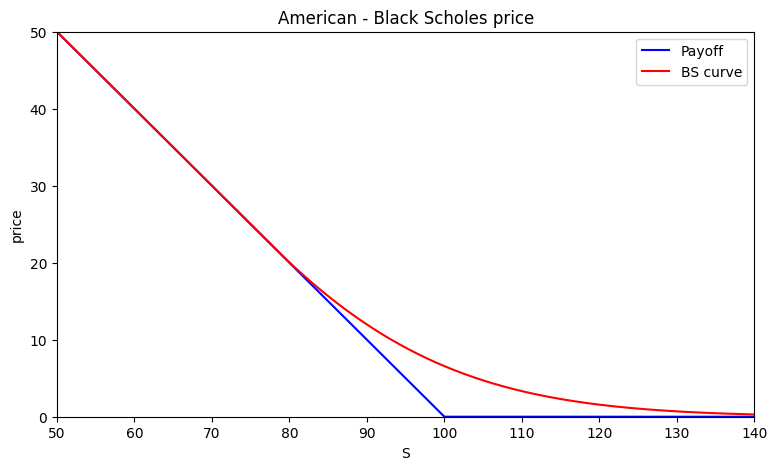

In [30]:
fig = plt.figure(figsize=(9, 5))
BS.plot([50, 140, 0, 50])

In [31]:
payoff = BS.payoff_f(BS.S_vec).reshape(len(BS.S_vec), 1)  # Transform the payoff in a column vector
mesh = (BS.mesh - payoff)[1:-1, :-1]  # I remove the boundary terms
optimal_indeces = np.argmax(np.abs(mesh) > 1e-10, axis=0)  # I introduce the error 1e-10
T_vec = np.linspace(0, BS.T, N_time)  # Time vector

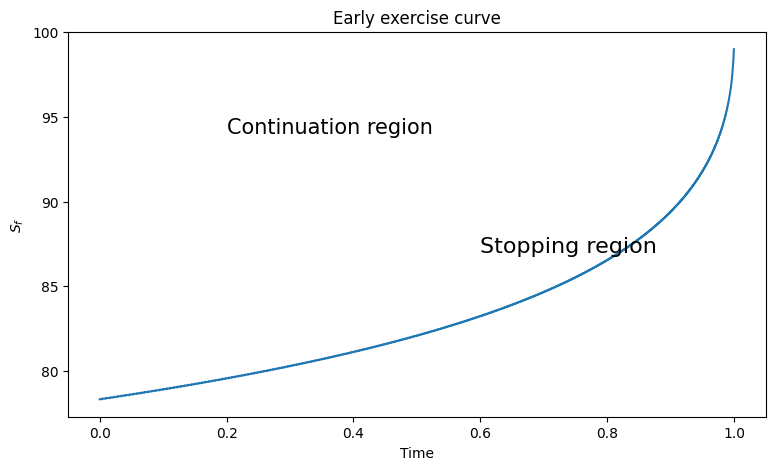

In [32]:
fig = plt.figure(figsize=(9, 5))
plt.plot(T_vec[:-1], BS.S_vec[optimal_indeces])
plt.text(0.2, 94, "Continuation region", fontsize=15)
plt.text(0.6, 87, "Stopping region", fontsize=16)
plt.xlabel("Time")
plt.ylabel("$S_f$")
plt.title("Early exercise curve")
plt.show()

#### Binomial tree

In [33]:
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.035  # risk free rate
sig = 0.2  # diffusion coefficient or volatility

In [34]:
N = 25000  # number of periods or number of time steps
payoff = "put"  # payoff

dT = float(T) / N  # Delta t
u = np.exp(sig * np.sqrt(dT))  # up factor
d = 1.0 / u  # down factor

V = np.zeros(N + 1)  # initialize the price vector
S_T = np.array([(S0 * u**j * d ** (N - j)) for j in range(N + 1)])  # price S_T at time T

a = np.exp(r * dT)  # risk free compound return
p = (a - d) / (u - d)  # risk neutral up probability
q = 1.0 - p  # risk neutral down probability

if payoff == "call":
    V[:] = np.maximum(S_T - K, 0.0)
elif payoff == "put":
    V[:] = np.maximum(K - S_T, 0.0)

for i in range(N - 1, -1, -1):
    V[:-1] = np.exp(-r * dT) * (p * V[1:] + q * V[:-1])  # the price vector is overwritten at each step
    S_T = S_T * u  # it is a tricky way to obtain the price at the previous time step
    if payoff == "call":
        V = np.maximum(V, S_T - K)
    elif payoff == "put":
        V = np.maximum(V, K - S_T)

print("American BS Tree Price: ", V[0])

American BS Tree Price:  6.570166616871246


## Exotic Option

In [35]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

In [36]:
# Option variables
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.035  # risk free rate
sig = 0.2  # diffusion coefficient or volatility
X0 = np.log(S0)  # logprice
B = 120  # Barrier 1
BB = 90  # Barrier 2

### Binary/digital options

#### Closed formula

In [37]:
d2 = (np.log(S0 / K) + (r - sig**2 / 2) * T) / (sig * np.sqrt(T))
N2 = ss.norm.cdf(d2)
closed_digital = np.exp(-r * T) * N2
print("The price of the ATM digital call option by closed formula is: ", closed_digital)

The price of the ATM digital call option by closed formula is:  0.5116672071325179


#### Monte Carlo

In [38]:
np.random.seed(seed=42)
N_simulation = 20000000
W = (r - sig**2 / 2) * T + ss.norm.rvs(loc=0, scale=sig, size=N_simulation)
S_T = S0 * np.exp(W)

MC_digital = np.exp(-r * T) * np.mean(S_T > K)
digital_std_err = np.exp(-r * T) * ss.sem(S_T > K)
print("The price of the ATM digital call option by Monte Carlo is: ", MC_digital)
print("with standard error: ", digital_std_err)

The price of the ATM digital call option by Monte Carlo is:  0.51183025534961
with standard error:  0.00010776267166593986


#### PDE method

In [39]:
Nspace = 6000  # M space steps
Ntime = 6000  # N time steps
S_max = 3 * float(K)
S_min = float(K) / 3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)  # time discretization
Payoff = np.where(np.exp(x) > K, 1, 0)  # Binary payoff

V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = 1  # boundary condition
V[0, :] = 0  # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig * sig
dxx = dx * dx
a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i]
    offset[-1] = c * V[-1, i]
    V[1:-1, i] = DD.solve(V[1:-1, i + 1] - offset)

# finds the option at S0
oPrice = np.interp(X0, x, V[:, 0])
print("The price of the ATM digital call option by PDE is: ", oPrice)

The price of the ATM digital call option by PDE is:  0.5116665597521938


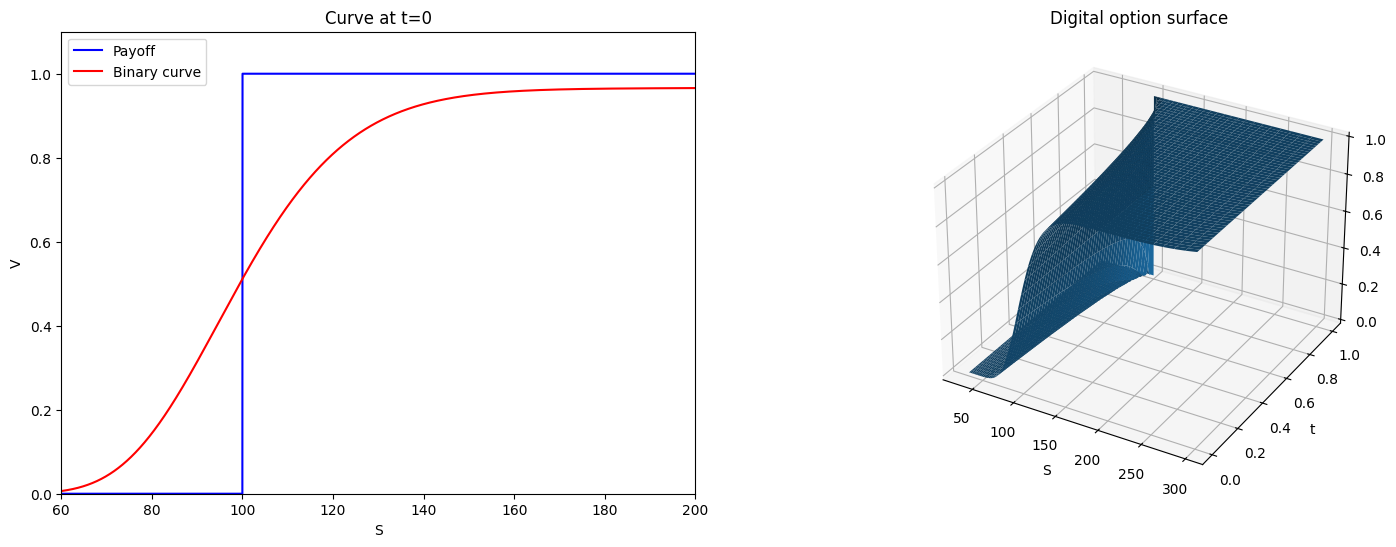

In [40]:
S = np.exp(x)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")
ax1.plot(S, Payoff, color="blue", label="Payoff")
ax1.plot(S, V[:, 0], color="red", label="Binary curve")
ax1.set_xlim(60, 200)
ax1.set_ylim(0, 1.1)
ax1.set_xlabel("S")
ax1.set_ylabel("V")
ax1.legend(loc="upper left")
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Digital option surface")
ax2.set_xlabel("S")
ax2.set_ylabel("t")
ax2.set_zlabel("V")
plt.show()

### Barrier options

In [41]:
d1 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r + sig**2 / 2) * t)
d2 = lambda t, s: 1 / (sig * np.sqrt(t)) * (np.log(s) + (r - sig**2 / 2) * t)

In [42]:
closed_barrier_u = (
    S0 * (ss.norm.cdf(d1(T, S0 / K)) - ss.norm.cdf(d1(T, S0 / B)))
    - np.exp(-r * T) * K * (ss.norm.cdf(d2(T, S0 / K)) - ss.norm.cdf(d2(T, S0 / B)))
    - B * (S0 / B) ** (-2 * r / sig**2) * (ss.norm.cdf(d1(T, B**2 / (S0 * K))) - ss.norm.cdf(d1(T, B / S0)))
    + np.exp(-r * T)
    * K
    * (S0 / B) ** (-2 * r / sig**2 + 1)
    * (ss.norm.cdf(d2(T, B**2 / (S0 * K))) - ss.norm.cdf(d2(T, B / S0)))
)

In [43]:
print("The price of the Up and Out call option by closed formula is: ", closed_barrier_u)

The price of the Up and Out call option by closed formula is:  1.1615536798122559


In [44]:
closed_barrier_d = S0 * (BB / S0) ** (1 + 2 * r / sig**2) * (ss.norm.cdf(d1(T, BB**2 / (S0 * K)))) - np.exp(
    -r * T
) * K * (BB / S0) ** (-1 + 2 * r / sig**2) * (ss.norm.cdf(d2(T, BB**2 / (S0 * K))))

In [45]:
print("The price of the Down and In call option by closed formula is: ", closed_barrier_d)

The price of the Down and In call option by closed formula is:  1.701611346364901


#### Monte Carlo

In [46]:
# correction
beta1 = 0.5826
B = B * np.exp( - beta1 * np.sqrt(dt) * sig)
BB = BB * np.exp(beta1 * np.sqrt(dt) * sig)

In [47]:
%%time
np.random.seed(seed=42)
N = 10000
paths = 20000
dt = T / (N - 1)  # time interval

# path generation
X_0 = np.zeros((paths, 1))
increments = ss.norm.rvs(loc=(r - sig**2 / 2) * dt, scale=np.sqrt(dt) * sig, size=(paths, N - 1))
X = np.concatenate((X_0, increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

M = np.amax(S, axis=1)  # maximum of each path
MM = np.amin(S, axis=1)  # minimum of each path

# Up and Out   --  Discounted expected payoff
MC_barrier_u = np.exp(-r * T) * (np.maximum(S[:, -1] - K, 0) @ (M < B)) / paths
barrier_std_err_u = np.exp(-r * T) * ss.sem((np.maximum(S[:, -1] - K, 0) * (M < B)))

print("The price of the Up and Out call option by Monte Carlo is: ", MC_barrier_u)
print("with standard error: ", barrier_std_err_u)
print()

# Down and In
MC_barrier_d = np.exp(-r * T) * (np.maximum(S[:, -1] - K, 0) @ (MM <= BB)) / paths
barrier_std_err_d = np.exp(-r * T) * ss.sem((np.maximum(S[:, -1] - K, 0) * (MM <= BB)))

print("The price of the Down and In call option by Monte Carlo is: ", MC_barrier_d)
print("with standard error: ", barrier_std_err_d)

The price of the Up and Out call option by Monte Carlo is:  1.1354341254328006
with standard error:  0.022079647034462926

The price of the Down and In call option by Monte Carlo is:  1.7007445281013338
with standard error:  0.0399796378332013
CPU times: user 10.5 s, sys: 2.07 s, total: 12.5 s
Wall time: 12.6 s


#### PDE method - Up and Out

In [48]:
# PDE
Nspace = 14000  # M space steps
Ntime = 10000  # N time steps
S_max = B  # The max of S corresponds to the Barrier
S_min = float(K) / 3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = 0  # boundary condition
V[0, :] = 0  # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig * sig
dxx = dx * dx
a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i]
    offset[-1] = c * V[-1, i]
    V[1:-1, i] = DD.solve(V[1:-1, i + 1] - offset)

# finds the option at S0
oPrice = np.interp(X0, x, V[:, 0])
print("The price of the Up and Out option by PDE is: ", oPrice)

The price of the Up and Out option by PDE is:  1.1316897150355167


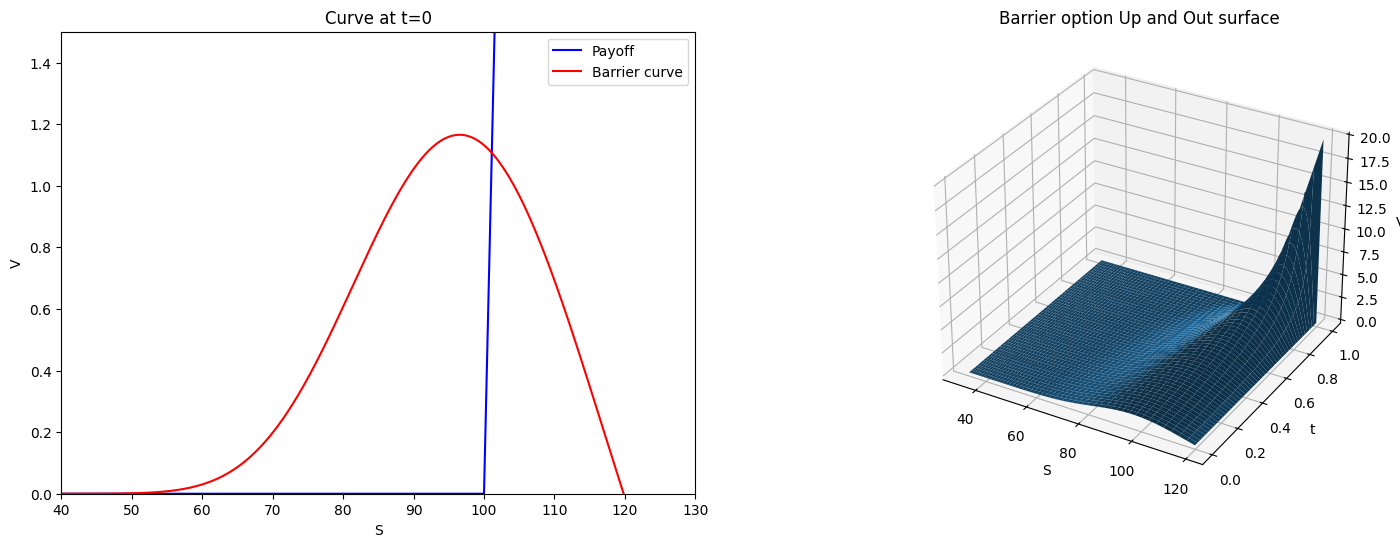

In [49]:
S = np.exp(x)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.plot(S, Payoff, color="blue", label="Payoff")
ax1.plot(S, V[:, 0], color="red", label="Barrier curve")
ax1.set_xlim(40, 130)
ax1.set_ylim(0, 1.5)
ax1.set_xlabel("S")
ax1.set_ylabel("V")
ax1.legend(loc="upper right")
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Barrier option Up and Out surface")
ax2.set_xlabel("S")
ax2.set_ylabel("t")
ax2.set_zlabel("V")
plt.show()

#### PDE method - Down and In

In [50]:
# PDE for vanilla
Nspace = 5000  # M space steps
Ntime = 5000  # N time steps
S_max = K * 3  # The max of S corresponds to the Barrier
S_min = K / 3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1
B_log = np.log(BB)

x_b, dx = np.linspace(B_log, x_max, Nspace, retstep=True)  # space discretization starting from the barrier
x = np.concatenate((np.arange(B_log, x_min, -dx)[::-1][:-1], x_b))  # total x vector
N_tot = len(x)

T_array, dt = np.linspace(0, T, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

V = np.zeros((N_tot, Ntime))  # grid initialization
offset = np.zeros(N_tot - 2)  # vector to be used for the boundary terms

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = np.exp(x_max) - K * np.exp(-r * T_array[::-1])  # boundary condition
V[0, :] = 0  # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig * sig
dxx = dx * dx
a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(N_tot - 2, N_tot - 2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i]
    offset[-1] = c * V[-1, i]
    V[1:-1, i] = DD.solve(V[1:-1, i + 1] - offset)

# finds the option at S0
oPrice = np.interp(X0, x, V[:, 0])
print("The price of the vanilla option by PDE is: ", oPrice)

The price of the vanilla option by PDE is:  9.667260521704131


In [51]:
# PDE for barrier
VB = V[-Nspace:, :]
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

VB[:, -1] = 0  # terminal condition
V[-1, :] = 0  # lateral condition

# construction of the tri-diagonal matrix D
sig2 = sig * sig
dxx = dx * dx
a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * VB[0, i]
    offset[-1] = c * VB[-1, i]
    VB[1:-1, i] = DD.solve(VB[1:-1, i + 1] - offset)

# finds the option at S0
oPrice = np.interp(X0, x_b, VB[:, 0])
print("The price of the Down and In option by PDE is: ", oPrice)

The price of the Down and In option by PDE is:  1.753323938280021


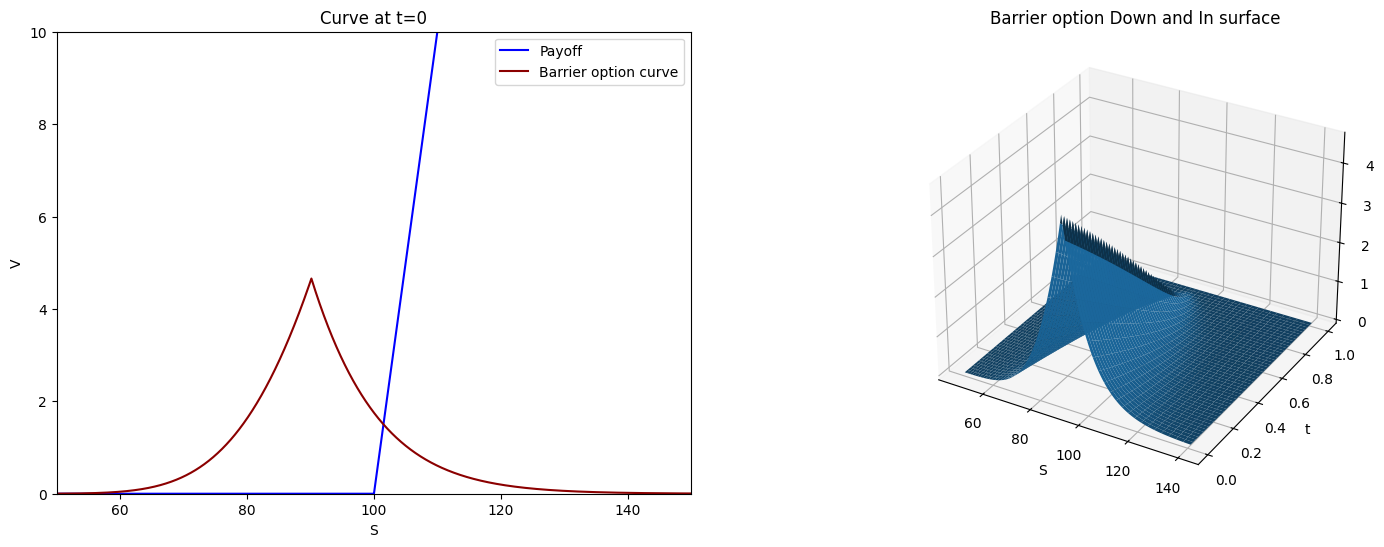

In [52]:
S = np.exp(x)
S_b = np.exp(x_b)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.plot(S, Payoff, color="blue", label="Payoff")
ax1.plot(S, V[:, 0], color="darkred", label="Barrier option curve")
ax1.set_xlim(50, 150)
ax1.set_ylim(0, 10)
ax1.set_xlabel("S")
ax1.set_ylabel("V")
ax1.legend(loc="upper right")
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S[1500:6000])
ax2.plot_surface(Y, X, V[1500:6000, :])
ax2.set_title("Barrier option Down and In surface")
ax2.set_xlabel("S")
ax2.set_ylabel("t")
ax2.set_zlabel("V")
plt.show()

### Asian options

#### Monte Carlo

In [53]:
%%time
np.random.seed(seed=41)
N = 10000
paths = 20000
dt = T / (N - 1)  # time interval

# path generation
X_0 = np.zeros((paths, 1))
increments = ss.norm.rvs(loc=(r - sig**2 / 2) * dt, scale=np.sqrt(dt) * sig, size=(paths, N - 1))
X = np.concatenate((X_0, increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

A = np.mean(S, axis=1)  # Average of each path
# A = S[:,-1]                 # Uncomment to retrieve the Black-Scholes price

# FIXED STRIKE
MC_asian_fixed = np.exp(-r * T) * np.mean(np.maximum(A - K, 0))
asian_fixed_std_err = np.exp(-r * T) * ss.sem(np.maximum(A - K, 0))
print("The price of the fixed strike average call option by Monte Carlo is: ", MC_asian_fixed)
print("with standard error: ", asian_fixed_std_err)
print()

# FLOAT STRIKE
MC_asian_float = np.exp(-r * T) * np.mean(np.maximum(S[:, -1] - A, 0))
asian_float_std_err = np.exp(-r * T) * ss.sem(np.maximum(S[:, -1] - A, 0))
print("The price of the float strike average call option by Monte Carlo is: ", MC_asian_float)
print("with standard error: ", asian_float_std_err)
print()

The price of the fixed strike average call option by Monte Carlo is:  5.446554927613741
with standard error:  0.055322058241839625

The price of the float strike average call option by Monte Carlo is:  5.51972780624247
with standard error:  0.05877964853611856

CPU times: user 10.2 s, sys: 1.66 s, total: 11.8 s
Wall time: 12 s


#### Fixed strike. PDE method

In [54]:
def gamma(t):
    return 1 / (r * T) * (1 - np.exp(-r * (T - t)))

def get_X0(S0):
    """function that computes the variable x defined above"""
    return gamma(0) * S0 - np.exp(-r * T) * K

In [55]:
# PDE algorithm
Nspace = 6000  # M space steps
Ntime = 6000  # N time steps
y_max = 60  # A2
y_min = -60  # A1

y, dy = np.linspace(y_min, y_max, Nspace, retstep=True)  # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(y, 0)  # payoff

G = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

G[:, -1] = Payoff  # terminal conditions
G[-1, :] = y_max  # boundary condition
G[0, :] = 0  # boundary condition

for n in range(Ntime - 2, -1, -1):
    # construction of the tri-diagonal matrix D
    sig2 = sig * sig
    dyy = dy * dy
    a = -0.5 * (dt / dyy) * sig2 * (gamma(T_array[n]) - y[1:-1]) ** 2
    b = 1 + (dt / dyy) * sig2 * (gamma(T_array[n]) - y[1:-1]) ** 2  # main diagonal
    a0 = a[0]
    cM = a[-1]  # boundary terms
    aa = a[1:]
    cc = a[:-1]  # upper and lower diagonals
    D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()

    # backward computation
    offset[0] = a0 * G[0, n]
    offset[-1] = cM * G[-1, n]
    G[1:-1, n] = spsolve(D, (G[1:-1, n + 1] - offset))

X0 = get_X0(S0)
oPrice = S0 * np.interp(X0 / S0, y, G[:, 0])
print("The price of the Fixed Strike Asian option by PDE is: ", oPrice)

The price of the Fixed Strike Asian option by PDE is:  5.417947407005549


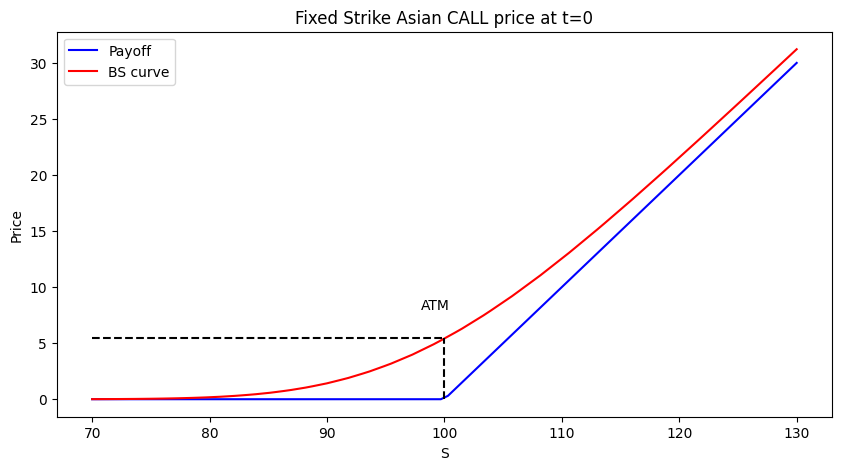

In [56]:
S = np.linspace(70, 130, 100)
asian_PDE = S * np.interp(get_X0(S) / S, y, G[:, 0])

fig = plt.figure(figsize=(10, 5))
plt.plot(S, np.maximum(S - K, 0), color="blue", label="Payoff")
plt.plot(S, asian_PDE, color="red", label="BS curve")
plt.xlabel("S")
plt.ylabel("Price")
plt.text(98, 8, "ATM")
plt.plot([S0, S0], [0, oPrice], "k--")
plt.plot([70, S0], [oPrice, oPrice], "k--")
plt.legend(loc="upper left")
plt.title("Fixed Strike Asian CALL price at t=0")
plt.show()

#### Floating strike. PDE method

In [57]:
Nspace = 4000  # M space steps
Ntime = 7000  # N time steps
x_max = 10  # A2
x_min = 0  # A1
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T_array, dt = np.linspace(0.0001, T, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(x - 1, 0)  # Call payoff

V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms
V[:, -1] = Payoff  # terminal conditions
V[-1, :] = x_max - 1  # boundary condition
V[0, :] = 0  # boundary condition

for n in range(Ntime - 2, -1, -1):
    # construction of the tri-diagonal matrix D
    sig2 = sig * sig
    dxx = dx * dx
    max_part = np.maximum(x[1:-1] * (r - (x[1:-1] - 1) / T_array[n]), 0)  # upwind positive part
    min_part = np.minimum(x[1:-1] * (r - (x[1:-1] - 1) / T_array[n]), 0)  # upwind negative part

    a = min_part * (dt / dx) - 0.5 * (dt / dxx) * sig2 * (x[1:-1]) ** 2
    b = (
        1 + dt * (r - (x[1:-1] - 1) / T_array[n]) + (dt / dxx) * sig2 * (x[1:-1]) ** 2 + dt / dx * (max_part - min_part)
    )  # main diagonal
    c = -max_part * (dt / dx) - 0.5 * (dt / dxx) * sig2 * (x[1:-1]) ** 2

    a0 = a[0]
    cM = c[-1]  # boundary terms
    aa = a[1:]
    cc = c[:-1]  # upper and lower diagonals
    D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()  # matrix D

    # backward computation
    offset[0] = a0 * V[0, n]
    offset[-1] = cM * V[-1, n]
    V[1:-1, n] = spsolve(D, (V[1:-1, n + 1] - offset))

# finds the option at S0, assuming it is ATM i.e. x=s/a=1
oPrice = S0 * np.interp(1, x, V[:, 0])
print("The price of the Floating Strike Asian option by PDE is: ", oPrice)

The price of the Floating Strike Asian option by PDE is:  5.478818157598196


In [58]:
S = np.linspace(10, 200, 100)
A = np.linspace(80, 120, 100)
VV = np.zeros((100, 100))
for i in range(len(S)):
    for j in range(len(A)):
        VV[i, j] = A[j] * np.interp(S[i] / A[j], x, V[:, 0])

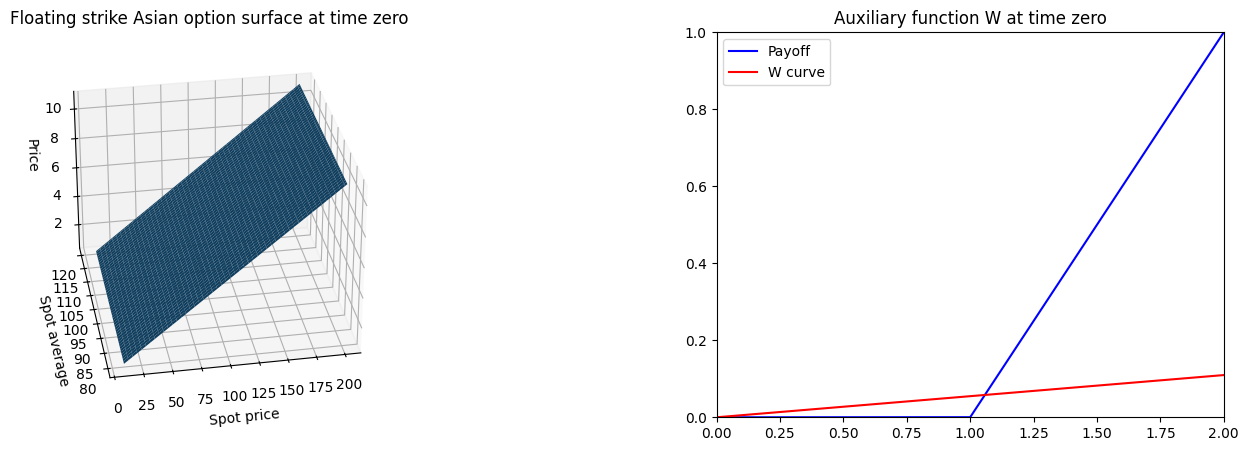

In [59]:
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])
ax1 = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])

X, Y = np.meshgrid(A, S)
ax1.plot_surface(Y, X, VV)
ax1.set_title("Floating strike Asian option surface at time zero")
ax1.set_xlabel("Spot price")
ax1.set_ylabel("Spot average")
ax1.set_zlabel("Price")
ax1.view_init(30, -100)

ax2.plot(x, Payoff, color="blue", label="Payoff")
ax2.plot(x, V[:, 0], color="red", label="W curve")
ax2.set_xlim(0, 2)
ax2.set_ylim(0, 1)
ax2.set_title("Auxiliary function W at time zero")
ax2.legend(loc="upper left")
plt.show()